In [3]:
import pymongo
import re
import pprint
import json
import jieba
from collections import Counter
import time
import math
import logging
from gensim.models import word2vec
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [4]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import  re
import os 
import codecs
from sklearn import feature_extraction
import mpld3

In [6]:
review = open('../US.20171130.txt').read().split(','+'\"')

In [7]:
type(review)

list

In [8]:
review[:5]

['"This funko was pretty good. Unfortunately the packing was completely smashed in on the side despite it having a ""inspected"" or ""certified"" sticker on the bottom. Also the strand doesn\'t fit the actual pop but that\'s more of a manufacturing complaint as I\'ve had that happen to me with the pop figure before."',
 'I was very excited when I found out that I got a Chase Demogorgon with the mouth closed. A little bummed that one of the corners of the box has some damage due to there not being enough protection in the shipping box. But, although there\'s a little flaw, I am still happy with it."',
 'I ordered this for my 8yr old nephew he is a big fan of the show. After reading the reviews I was concerned about it\'s structure but it stands on its own well. I knew about the clear stand because of reading a review if not I wouldn\'t know to look for it. I can see how the head is too big for the body and can tip over but it stands well (I bumped the shelf a couple times and it didn\'t

In [29]:
# 载入 nltk 的英文停用词作为“stopwords”变量
stopwords = nltk.corpus.stopwords.words('english')
print (stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [10]:
# 载入 nltk 的 SnowballStemmer 作为“stemmer”变量(把一些動詞形式轉換成原型)
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [11]:
# 分詞器
def tokenize_and_stem(text):
    # 首先分句，接着分词，而标点也会作为词例存在
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # 过滤所有不含字母的词例（例如：数字、纯标点）
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [12]:
# 詞幹分詞器
def tokenize_only(text):
    # 首先分句，接着分词，而标点也会作为词例存在
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # 过滤所有不含字母的词例（例如：数字、纯标点）
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [13]:
# 扩充列表后变成了非常庞大的二维（flat）词汇表
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in review:
    allwords_stemmed = tokenize_and_stem(i) #对每个电影的剧情简介进行分词和词干化
    totalvocab_stemmed.extend(allwords_stemmed) # 扩充“totalvocab_stemmed”列表

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')


print (vocab_frame.head())

there are 392073 items in vocab_frame
         words
this      this
funko    funko
was        was
pretti  pretty
good      good


In [57]:
# 定义向量化参数
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000, #一個詞在80％的文章都出現過（沒有鑑別度）/最多關鍵詞的數量
                                 min_df=0.05, stop_words='english', #一個詞至少要在5％的文章都出現過/去除停用詞
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))


In [58]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(review) # 向量化剧情简介文本

CPU times: user 14.7 s, sys: 177 ms, total: 14.9 s
Wall time: 15.1 s


In [59]:
print(tfidf_matrix.shape)

(2906, 197)


In [60]:
print(tfidf_matrix)

  (0, 139)	0.301501194224
  (0, 74)	0.222227098616
  (0, 40)	0.357164952472
  (0, 52)	0.246305624572
  (0, 116)	0.174728540362
  (0, 68)	0.301808945266
  (0, 4)	0.325193388771
  (0, 1)	0.173955286233
  (0, 185)	0.313283768846
  (0, 66)	0.33008859315
  (0, 19)	0.338413752795
  (0, 53)	0.303677347449
  (1, 1)	0.192654552751
  (1, 186)	0.208888821754
  (1, 59)	0.38053653556
  (1, 75)	0.253580588943
  (1, 106)	0.418378404789
  (1, 26)	0.649604632783
  (1, 82)	0.336321044449
  (2, 74)	0.136298941038
  (2, 116)	0.214333131907
  (2, 1)	0.106692304626
  (2, 106)	0.115849211906
  (2, 130)	0.19279297297
  (2, 122)	0.102374816509
  :	:
  (2905, 82)	0.241291253042
  (2905, 105)	0.0737333922148
  (2905, 97)	0.129670165621
  (2905, 42)	0.317519909531
  (2905, 79)	0.0680540032403
  (2905, 72)	0.269610137216
  (2905, 120)	0.103811874384
  (2905, 111)	0.160575251624
  (2905, 25)	0.338419257449
  (2905, 164)	0.255508884883
  (2905, 36)	0.0867693471977
  (2905, 60)	0.123100665064
  (2905, 181)	0.08016749

In [61]:
terms = tfidf_vectorizer.get_feature_names()

In [62]:
type(terms)

list

In [63]:
print(terms)

["'m", "'s", 'abl', 'absolut', 'actual', 'ador', 'age', 'alreadi', 'alway', 'amazon', 'ani', 'anoth', 'arriv', 'assembl', 'away', 'awesom', 'babi', 'batteri', 'becaus', 'befor', 'best', 'better', 'big', 'birthday', 'bit', 'bought', 'box', 'boy', 'build', 'buy', 'ca', "ca n't", 'came', 'car', 'child', 'children', 'christma', 'christma gift', 'color', 'come', 'complet', 'cool', 'cute', 'daughter', 'daughter love', 'day', 'definit', 'design', 'did', "did n't", 'differ', 'disappoint', 'doe', "doe n't", 'easi', 'easili', 'enjoy', 'everi', 'everyth', 'excit', 'expect', 'extra', 'fall', 'far', 'favorit', 'feel', 'figur', 'fine', 'fit', 'friend', 'fun', 'gave', 'gift', 'girl', 'good', 'got', 'granddaught', 'grandson', 'grandson love', 'great', 'hand', 'handl', 'happi', 'hard', 'help', 'high', 'high recommend', 'hit', 'hold', 'hope', 'hour', 'hous', 'howev', 'includ', 'insid', 'instruct', 'issu', 'item', 'just', 'kid', 'kid love', 'know', 'learn', 'lego', 'light', 'like', 'littl', 'll', 'long',

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [65]:
print(dist)

[[ -2.22044605e-16   9.66486722e-01   9.13700876e-01 ...,   1.00000000e+00
    9.04120483e-01   8.40668923e-01]
 [  9.66486722e-01  -2.22044605e-16   9.30976433e-01 ...,   9.11615967e-01
    8.60066492e-01   8.47600675e-01]
 [  9.13700876e-01   9.30976433e-01  -2.22044605e-16 ...,   9.33911301e-01
    8.87587112e-01   9.53812874e-01]
 ..., 
 [  1.00000000e+00   9.11615967e-01   9.33911301e-01 ...,   0.00000000e+00
    8.23853268e-01   8.59952021e-01]
 [  9.04120483e-01   8.60066492e-01   8.87587112e-01 ...,   8.23853268e-01
    0.00000000e+00   6.25290784e-01]
 [  8.40668923e-01   8.47600675e-01   9.53812874e-01 ...,   8.59952021e-01
    6.25290784e-01  -2.22044605e-16]]


## K-means

In [23]:
from sklearn.cluster import KMeans
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 13.2 s, sys: 182 ms, total: 13.4 s
Wall time: 13.9 s


In [25]:
from __future__ import print_function

# 按离质心的距离排列聚类中心，由近到远
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :20]: # 每个聚类选 20 个词
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() # 空行
    print() # 空行

Cluster 0 words: b'colors', b'great', b'love', b'used', b'like', b'set', b'just', b"n't", b"'s", b'nice', b'kids', b'little', b'good', b'very', b'makes', b'light', b'pretty', b'times', b'small', b'picture',

Cluster 1 words: b'puzzles', b'pieces', b'together', b'love', b'great', b'old', b"'s", b'easy', b'year', b"n't", b'very', b'fun', b'year', b'colors', b'work', b'like', b'picture', b'quality', b'nice', b'fit',

Cluster 2 words: b'months', b'months', b'old', b'love', b'toy', b"'s", b'playing', b'baby', b'little', b'great', b'just', b'like', b"n't", b'old', b'very', b'things', b'push', b'used', b'got', b'son',

Cluster 3 words: b'toy', b'love', b'playing', b"'s", b'little', b'great', b'son', b'kids', b'fun', b'very', b'like', b'just', b"n't", b'really', b'used', b'favorite', b'old', b'baby', b'grandsons', b'good',

Cluster 4 words: b'gift', b'love', b'christmas', b'great', b'grandsons', b'playing', b"'s", b'bought', b'perfect', b'christmas', b'son', b'got', b'like', b'little', b'cute'

In [26]:
##多维尺度分析MDS    
import os  # 为了使用 os.path.basename 函数
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
MDS()
# 将二位平面中绘制的点转化成两个元素（components）
# 设置为“precomputed”是因为我们提供的是距离矩阵
# 我们可以将“random_state”具体化来达到重复绘图的目的
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # 形如 (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


KeyError: 'title'

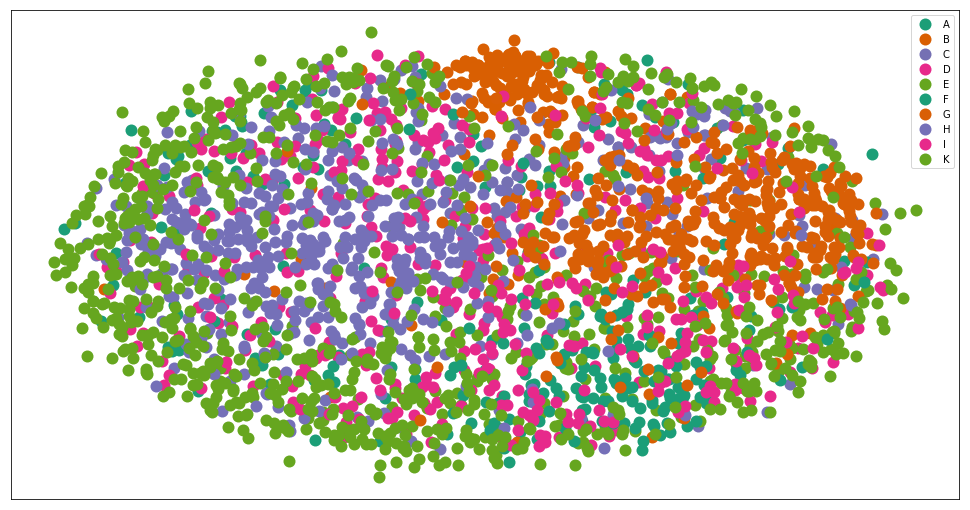

In [27]:
##可视化聚类
# 用字典设置每个聚类的颜色
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',5:'#1b9e78',6:'#d95f06',7:'#7570b8',8:'#e7298b',9:'#66a61f'}
# 用字典设置每个聚类名称
cluster_names = {0: 'A', 
                 1: 'B', 
                 2: 'C', 
                 3: 'D', 
                 4: 'E',
                 5: 'F',
                 6: 'G',
                 7: 'H',
                 8: 'I',
                 9: 'K'
                }
# 在 ipython 中内联（inline）演示 matplotlib 绘图
%matplotlib inline 

# 用 MDS 后的结果加上聚类编号和绘色创建 DataFrame
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

# 聚类归类
groups = df.groupby('label')


# 设置绘图
fig, ax = plt.subplots(figsize=(17, 9)) # 设置大小
ax.margins(0.05) # 可选项，只添加 5% 的填充（padding）来自动缩放（auto scaling）。

# 对聚类进行迭代并分布在绘图上
# 我用到了 cluster_name 和 cluster_color 字典的“name”项，这样会返回相应的 color 和 label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',          # 使用 x 坐标轴
        which='both',      # 同时使用主刻度标签（major ticks）和次刻度标签（minor ticks）
        bottom='off',      # 取消底部边缘（bottom edge）标签
        top='off',         # 取消顶部边缘（top edge）标签
        labelbottom='off')
    ax.tick_params(
        axis= 'y',         # 使用 y 坐标轴
        which='both',      # 同时使用主刻度标签（major ticks）和次刻度标签（minor ticks）
        left='off',      # 取消底部边缘（bottom edge）标签
        top='off',         # 取消顶部边缘（top edge）标签
        labelleft='off')

ax.legend(numpoints=1)  # 图例（legend）中每项只显示一个点

# 在坐标点为 x,y 处添加影片名作为标签（label）
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show() # 展示绘图

## 層次聚類

In [79]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist) # 聚类算法处理之前计算得到的距离，用 linkage_matrix 表示
fig, ax = plt.subplots(figsize=(15, 20)) # 设置大小
ax = dendrogram(linkage_matrix, orientation="right");

In [80]:
plt.tick_params(
        axis= 'x',          # 使用 x 坐标轴
        which='both',      # 同时使用主刻度标签（major ticks）和次刻度标签（minor ticks）
        bottom='off',      # 取消底部边缘（bottom edge）标签
        top='off',         # 取消顶部边缘（top edge）标签
    labelbottom='off')

In [81]:
plt.tight_layout() # 展示紧凑的绘图布局

In [82]:
plt.savefig('ward_clusters.png', dpi=200) # 保存图片为 ward_clusters

In [83]:
plt.close() 

## DBSCAN

In [162]:
DBSCAN(eps=0.5, min_samples=5, metric= dist, algorithm='auto', leaf_size=30, p=None, random_state=None)

NameError: name 'DBSCAN' is not defined